In [76]:
!pip install torchtext==0.6.0

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [79]:
import spacy
import sys
from torchtext.data import Field, BucketIterator
from torchtext.datasets import Multi30k
import torch
import torch.nn as nn
import torch.optim as optim
sys.path.append('drive/MyDrive/mlcs/transformer/')
import transformer_cp
import transformer

In [80]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

In [156]:
BATCH_SIZE = 128


In [82]:
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized):
  print(f"index {i}: {token.text}")

def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

# source, target
SRC = Field(tokenize=tokenize_de, init_token="", eos_token="", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="", eos_token="", lower=True, batch_first=True)


index 0: I
index 1: am
index 2: a
index 3: graduate
index 4: student
index 5: .


In [83]:
train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de",".en"), fields=(SRC, TRG))

In [84]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

29000 1014 1000


In [85]:
print(vars(train_dataset.examples[29])['src'])
print(vars(train_dataset.examples[29])['trg'])

['ein', 'junger', 'mann', 'in', 'einer', 'schwarz-gelben', 'jacke', 'blickt', 'etwas', 'an', 'und', 'lächelt', '.']
['a', 'young', 'man', 'in', 'a', 'black', 'and', 'yellow', 'jacket', 'is', 'gazing', 'at', 'something', 'and', 'smiling', '.']


In [86]:
# 사전을 만들자, 최소 2번 이상 등장한 단어만 선택
# stoi = string to index 단어가 매핑되는 인덱스 알려줌
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(len(SRC.vocab), len(TRG.vocab))
print(TRG.vocab.stoi["abcabc"]) # 없는 단어라면 그냥 0을 출력
print(TRG.vocab.stoi[TRG.pad_token]) # 빈 자리에는 1을 출력 - pad
print(TRG.vocab.stoi[""])
print(TRG.vocab.stoi["."])
print(TRG.vocab.stoi["hello"])

7852 5892
0
1
2
4
4111


In [87]:
# input은 한 문장이니까 문장안에 단어 수가 유사하게 만듦
# iterator 는 일반적인 dataloader 와 비슷하게 사용
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size = BATCH_SIZE,
    device = device
)

In [88]:
for i, batch in enumerate(train_iterator):
  src = batch.src
  trg = batch.trg

  print(f"첫번째 배치 크기:{trg.shape}")  # (128,37)

  for i in range(src.shape[1]): # 32개 단어로 이루어진 문장 128개
    print(f"인덱스:{i}:{src[0][i].item()}") # 단어 인덱스를 추출
  break # 첫 배치 중 첫 문장 만 확인

첫번째 배치 크기:torch.Size([128, 34])
인덱스:0:2
인덱스:1:4
인덱스:2:69
인덱스:3:31
인덱스:4:68
인덱스:5:19
인덱스:6:221
인덱스:7:139
인덱스:8:3
인덱스:9:2
인덱스:10:1
인덱스:11:1
인덱스:12:1
인덱스:13:1
인덱스:14:1
인덱스:15:1
인덱스:16:1
인덱스:17:1
인덱스:18:1
인덱스:19:1
인덱스:20:1
인덱스:21:1
인덱스:22:1
인덱스:23:1
인덱스:24:1
인덱스:25:1


In [161]:
INPUT_DIM = len(SRC.vocab) # 7852
OUTPUT_DIM = len(TRG.vocab) # 5892
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_FF_DIM = 512
DEC_FF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
# src_len = 37 +-
# trg_len = 31 +-
BATCH_SIZE = 128
LR = 0.001
PROGRESS_INTERVAL = 10
EPOCHS = 3
CLIP = 1

In [160]:
del enc
del dec
del model

In [162]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]  # 1
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]  # 1

enc = transformer_cp.Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_FF_DIM, ENC_DROPOUT, device)
dec = transformer_cp.Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_FF_DIM, DEC_DROPOUT, device)

model = transformer_cp.Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)


In [163]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("parameters:",count_parameters(model))

parameters: 9037572


In [164]:
def init_weights(m):
  if hasattr(m, 'weight') and m.weight.dim()>1:
    nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7852, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
     

In [165]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [166]:
def train(model, epochs, progress_interval, clip):
  train_loss_list=[]
  val_loss_list=[]
  best_val_loss = float('inf')

  for i in range(1, epochs+1):
    train_loss=0
    total_cnt=0
    correct_cnt=0
    model.train()

    for batch_i, batch in enumerate(train_iterator):
      if torch.cuda.is_available() is True:
        batch = batch.to(device)
      src = batch.src  # (batch_size, src_len) # <sos>,'i','am','a','student', <eos>
      trg = batch.trg  # (batch_size, trg_len) # <sos>,'je','suis','un','etudiant', <eos>

      optimizer.zero_grad()
      output, _ = model(src, trg[:,:-1])  # (batch_size, trg_len-1, output_dim)
      """ENCODER INPUT SRC :  <sos>,'i','am','a','student', <eos>
         DECODER INPUT TRG :  <sos>,'je','suis','un','etudiant'     """
      output_dim = output.shape[-1]

      output = output.contiguous().view(-1, output_dim) # (b_s*(trg_len-1), output_dim)
      trg = trg[:,1:].contiguous().view(-1)  # (b_s*(trg_len-1)) # target에서 <eos>빼줌
      """ENCODER OUPTUT SRC :  <sos>,'i','am','a','student'
         DECODER OUTPUT TRG :  'je','suis','un','etudiant',<eos>     """
      loss = criterion(output, trg)
      loss.backward()

      # for gradient stability
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()
      train_loss+=loss.item()
      if (batch_i+1)%progress_interval == 0:
        print(f"Training Epoch:{i}, Batch:{batch_i+1}, Loss:{train_loss/(batch_i+1):.4f}")

    train_loss /= len(train_iterator)
    train_loss_list.append(train_loss)
    print(f"Training Epoch:{i}, Average Loss:{train_loss:.4f}")

    model.eval()
    with torch.no_grad():
      val_loss=0
      for batch_i, batch in enumerate(valid_iterator):
        if torch.cuda.is_available() is True:
          batch = batch.to(device)

        src = batch.src
        trg = batch.trg

        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        val_loss += loss.item()
        total_cnt += trg.size(0)
        _, pred_label = torch.max(nn.functional.softmax(output,dim=1),1)
        correct_cnt += (pred_label==trg).sum().item()

      val_loss /= len(valid_iterator)
      val_loss_list.append(val_loss)
      acu = correct_cnt/total_cnt
      print(f"Validation Epoch:{i}, Average Loss:{val_loss:.4f}, Accuracy:{acu:.4f}")

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'transformer_ger_to_eng.pt')

  return model, train_loss_list, val_loss_list


In [167]:
model, train_loss_list, val_loss_list = train(model, EPOCHS, PROGRESS_INTERVAL, CLIP)

Training Epoch:1, Batch:10, Loss:7.2085
Training Epoch:1, Batch:20, Loss:6.4050
Training Epoch:1, Batch:30, Loss:6.0831
Training Epoch:1, Batch:40, Loss:5.8524
Training Epoch:1, Batch:50, Loss:5.6602
Training Epoch:1, Batch:60, Loss:5.4816
Training Epoch:1, Batch:70, Loss:5.3228
Training Epoch:1, Batch:80, Loss:5.1825
Training Epoch:1, Batch:90, Loss:5.0593
Training Epoch:1, Batch:100, Loss:4.9509
Training Epoch:1, Batch:110, Loss:4.8545
Training Epoch:1, Batch:120, Loss:4.7651
Training Epoch:1, Batch:130, Loss:4.6880
Training Epoch:1, Batch:140, Loss:4.6160
Training Epoch:1, Batch:150, Loss:4.5494
Training Epoch:1, Batch:160, Loss:4.4879
Training Epoch:1, Batch:170, Loss:4.4302
Training Epoch:1, Batch:180, Loss:4.3781
Training Epoch:1, Batch:190, Loss:4.3287
Training Epoch:1, Batch:200, Loss:4.2812
Training Epoch:1, Batch:210, Loss:4.2359
Training Epoch:1, Batch:220, Loss:4.1955
Training Epoch:1, Average Loss:4.1688
Validation Epoch:1, Average Loss:3.0653, Accuracy:0.3405
Training Epo

In [186]:
def translation_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
  model.eval()
  if isinstance(sentence, str):
    nlp = spacy.load('de')
    tokens = [token.text.lower() for token in nlp(sentence)]
  else:
    tokens = [token.lower() for token in sentence]

  tokens = [src_field.init_token]+tokens+[src_field.eos_token]

  if logging:
    print(f"전체 소스 토큰 : {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

  if logging:
    print(f"소스 토큰 인덱스 : {src_indexes}")

  src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)  # (1, src_len)

  src_mask = model.make_src_mask(src_tensor)
  print(src_mask)

  with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)

  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]  # 맨 처음 init 토큰 만 넣음

  for i in range(max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)  # (1,1)
    trg_mask = model.make_trg_mask(trg_tensor)
    #print(trg_mask)

    with torch.no_grad():
      output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

    pred_token = output.argmax(2)[:,-1].item() # output-dim 차원에서 가장 큰 index 추출해서, 그 index만 선택하고 다음 토큰으로 더함
    trg_indexes.append(pred_token)

    if pred_token==trg_field.vocab.stoi[trg_field.eos_token]:
      break

  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:], attention


In [189]:
example_idx = 10
src=vars(test_dataset.examples[example_idx])['src']
trg=vars(test_dataset.examples[example_idx])['trg']
print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translation_sentence(src, SRC, TRG, model, device, max_len=50, logging=True)
print(f"모델 출력 결과:{translation}")

attention.shape # (1,8,14,15)



소스 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
타겟 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
전체 소스 토큰 : ['', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '']
소스 토큰 인덱스 : [2, 7, 363, 9, 133, 69, 623, 564, 18, 779, 199, 19, 87, 3, 2]
tensor([[[[True, True, True, True, True, True, True, True, True, True, True,
           True, True, True, True]]]])
모델 출력 결과:['a', 'family', 'and', 'young', 'family', 'enjoying', 'their', 'mother', 'and', 'enjoying', 'their', 'mother', '.', '']


torch.Size([1, 8, 14, 15])

In [192]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
  assert n_rows*n_cols == n_heads
  fig = plt.figure(figsize=(15,25))
  for i in range(n_heads):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    _attention = attention.squeeze(0)[i].cpu().detach().numpy()

    cax = ax.matshow(_attention, cmap='bone')

    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['']+[t.lower() for t in sentence]+ [''], rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()

<ipython-input-192-ab9a324f5444>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['']+[t.lower() for t in sentence]+ [''], rotation=45)
<ipython-input-192-ab9a324f5444>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


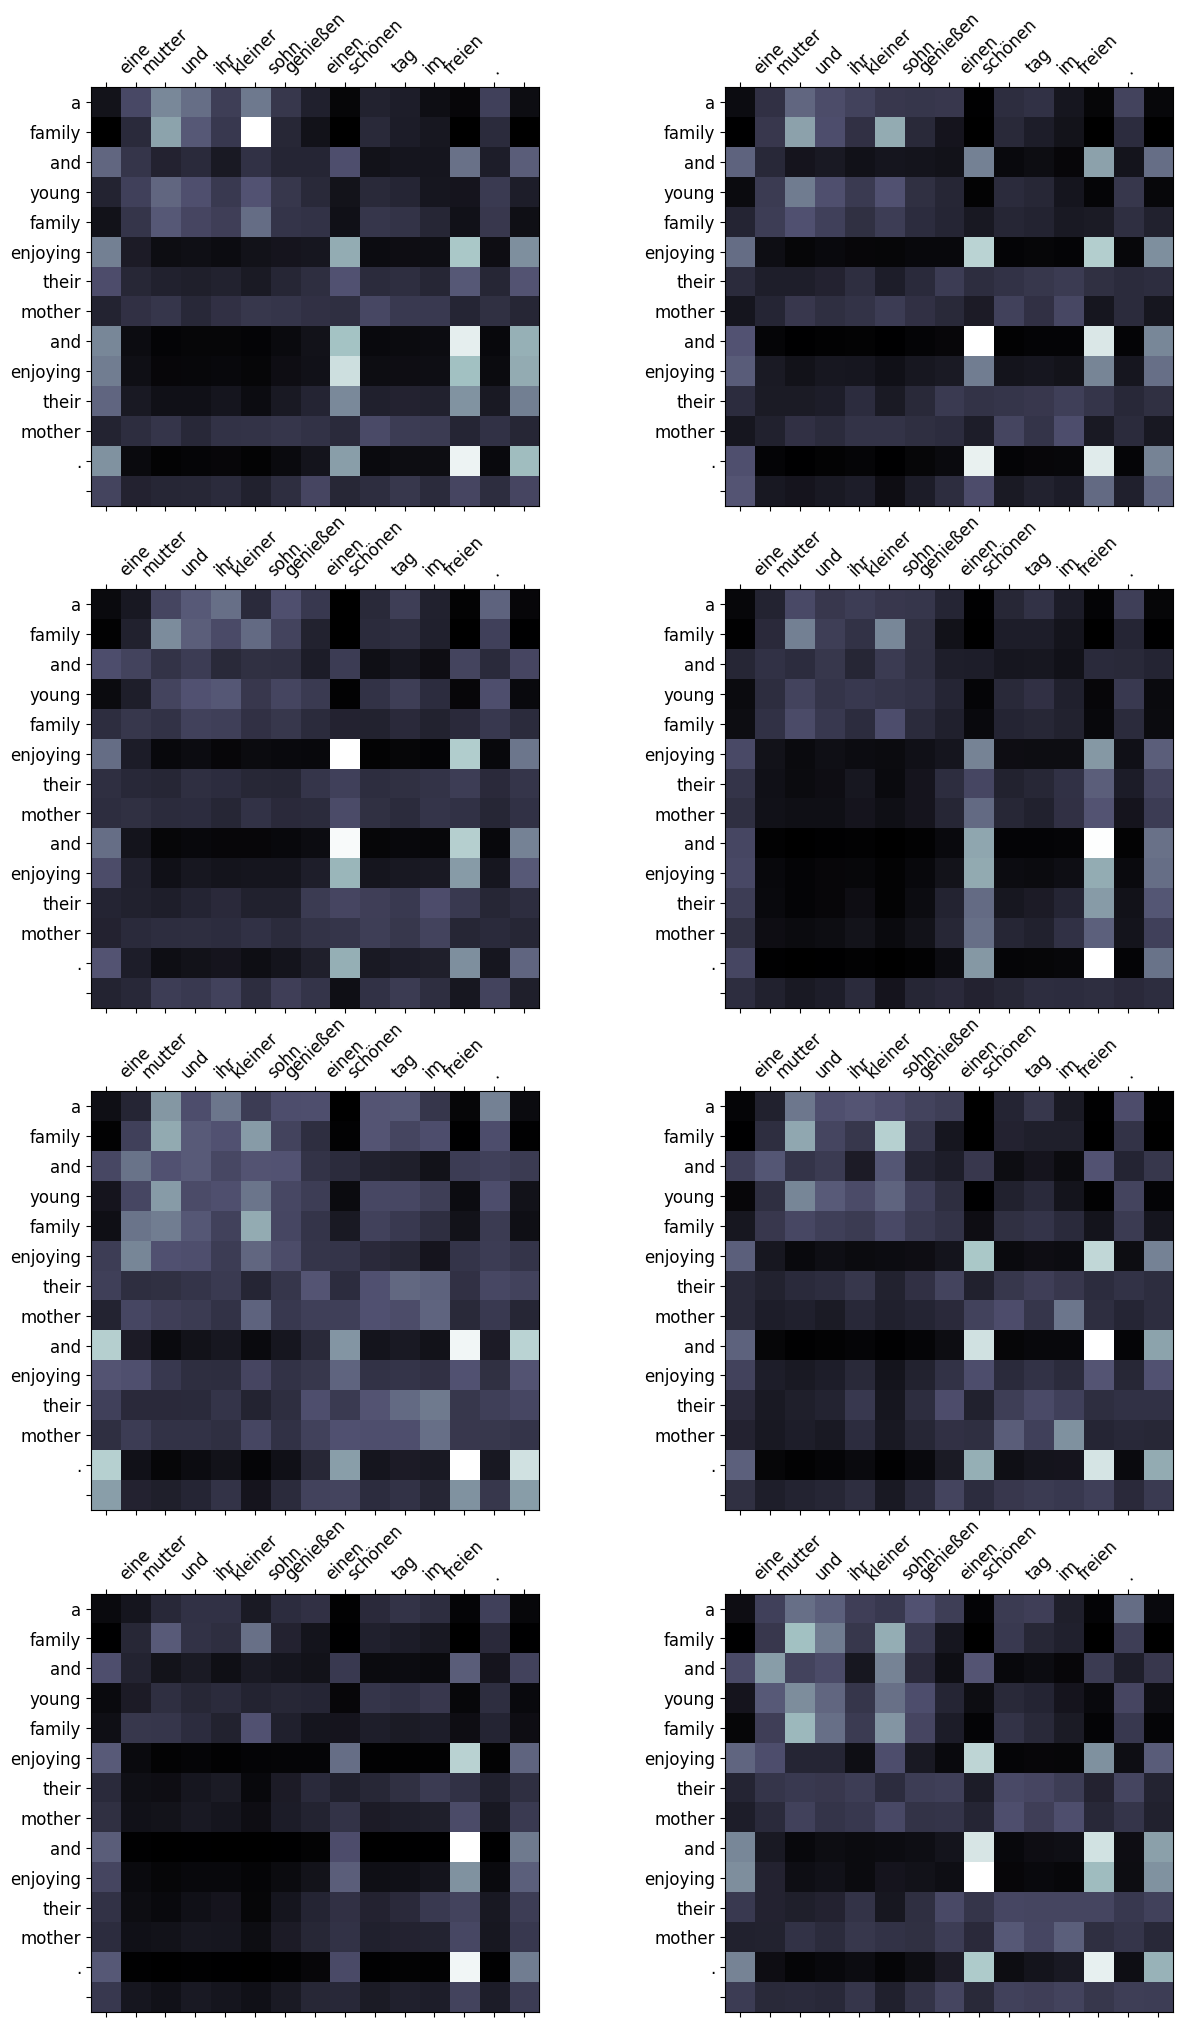

In [193]:
display_attention(src, translation, attention)